In [ ]:
import keras
import tensorflow as tf
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling



from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
#from tensorflow.python.keras.optimizers import Adam, RMSprop
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from imutils import paths
%matplotlib inline


In [ ]:
!git clone https://github.com/mohammedtlili/truck_recommandation.git


Cloning into 'truck_recommandation'...
remote: Enumerating objects: 17852, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 17852 (delta 4), reused 8 (delta 0), pack-reused 17834
Receiving objects: 100% (17852/17852), 121.27 MiB | 33.99 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Checking out files: 100% (19175/19175), done.


In [ ]:
# used from keras documentation (flow_from_directory method)

batch_size = 32
image_size = 160
target_size = (160, 160),


In [ ]:
## Create image generator
# folders with train dir & val dir
train_dir = '/content/truck_recommandation/dataset/train_set'
test_dir = '/content/truck_recommandation/dataset/test_set'
testing_dir = '/content/truck_recommandation/dataset/single_prediction'
input_shape = (image_size, image_size, 3)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, History
import os

In [ ]:
#os.mkdir('model')
os.makedirs('model', exist_ok=True)

In [ ]:
#Model saving based on validation accuracy score
filepath="model/M_categoriel-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [ ]:
# image augmentation technique to enrich our dataset(training set) without adding more images
# so get good performance  results with little or no overfitting even with the small amount of images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0)



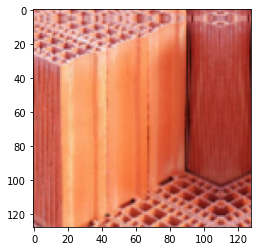

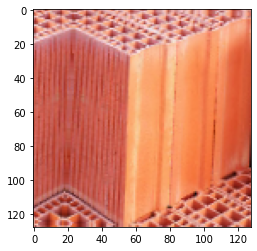

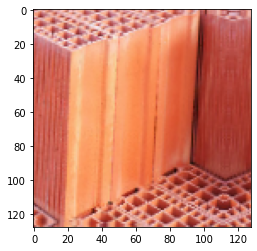

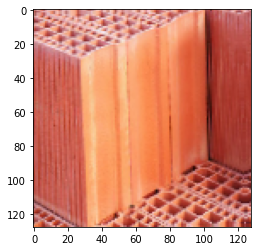

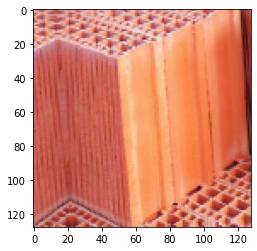

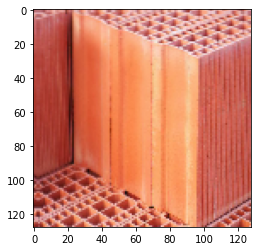

In [ ]:
img_path = '/content/truck_recommandation/dataset/train_set/camionette/Sans-titre-1-17.jpg'
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

In [ ]:


# create training set
# wanna get higher accuracy -> inccrease target_size
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True)





Found 14240 images belonging to 4 classes.


In [ ]:
# create testing set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True)

Found 3560 images belonging to 4 classes.


In [ ]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True)

Found 0 images belonging to 0 classes.


In [ ]:
train_generator.class_indices

{'camionette': 0, 'fourgon': 1, 'porteur': 2, 'utilitaire': 3}

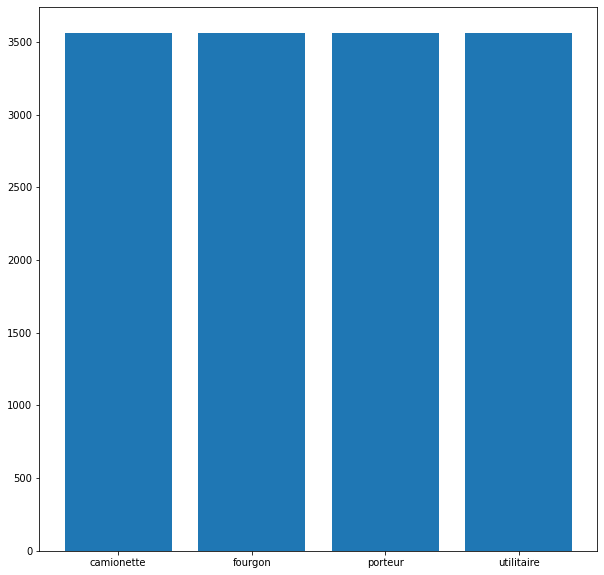

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(4):
    num_values.append(valdict[i])
plt.figure(figsize=(10,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


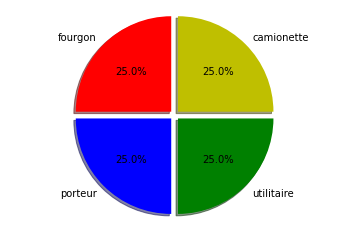

In [ ]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = [(counts)]
colors = ['y','r','b','g']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

['camionette', 'fourgon', 'porteur', 'utilitaire']
[]
OrderedDict([(0, 890), (1, 890), (2, 890), (3, 890)])


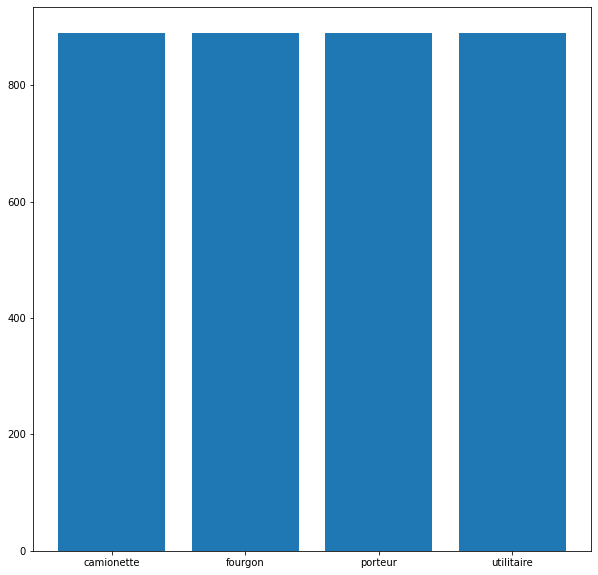

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = test_generator.classes
from collections import OrderedDict


classes = list(test_generator.class_indices.keys())
print(classes)
num_values = []
print(num_values)

unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
print(valdict)

for i in range(4):
  num_values.append(valdict[i])
plt.figure(figsize=(10,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


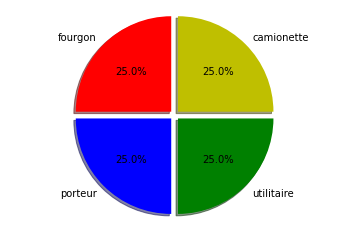

In [ ]:
import matplotlib.pyplot as plt

goal_types = list(test_generator.class_indices.keys())
unique, counts = np.unique(cls_test, return_counts=True)
goals = [(counts)]
colors = ['y','r','b','g']

plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')

plt.show()

In [ ]:
# Rescale the image to [-1, 1]
rescale = Rescaling(scale = 1./127.5, offset = -1)

In [ ]:
# Base model from the pre-trained model MobileNet V2

base_model = MobileNetV2(
                  input_shape = input_shape,
                  include_top = False,
                  weights = 'imagenet'
              )

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Take a look at the tensor dimension
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature Extraction
# Freeze the convolutional layer

In [ ]:
base_model.trainable = False

In [ ]:
# Base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

## Compile the model

In [ ]:
# Set the input layer
inputs = tf.keras.Input(shape = (160, 160, 3))
# Data augmentation
x = RandomFlip('horizontal')(inputs)
x = RandomRotation(0.2)(x)
x = Rescaling(scale = 1./127.5, offset = -1)(x)
# Feature extaction layer
x = base_model(x, training = False)
# Pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# Dense layer
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
# Final model
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Set the learning rate
base_learning_rate = 0.0001

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = base_learning_rate
    ),
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits = True
    ),
    metrics = ['accuracy']
)

In [ ]:
# Model architecture
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 160, 160, 3)      0         
 tation)                                                         
                                                                 
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0   

## Train the data


In [ ]:
# Set the number of epochs
initial_epochs = 10

# Train the data
final_model = model.fit(
    train_generator,
    epochs = initial_epochs,
    validation_data = test_generator
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


445/445 [==============================] - 361s 804ms/step - loss: 0.5755 - accuracy: 0.3102 - val_loss: 0.5344 - val_accuracy: 0.3938
Epoch 2/10
445/445 [==============================] - 357s 802ms/step - loss: 0.5454 - accuracy: 0.3648 - val_loss: 0.5272 - val_accuracy: 0.4067
Epoch 3/10
445/445 [==============================] - 359s 806ms/step - loss: 0.5369 - accuracy: 0.3861 - val_loss: 0.5271 - val_accuracy: 0.4107
Epoch 4/10
445/445 [==============================] - 356s 801ms/step - loss: 0.5292 - accuracy: 0.4089 - val_loss: 0.5231 - val_accuracy: 0.4197
Epoch 5/10
445/445 [==============================] - 365s 821ms/step - loss: 0.5257 - accuracy: 0.4093 - val_loss: 0.5214 - val_accuracy: 0.4219
Epoch 6/10
445/445 [==============================] - 365s 819ms/step - loss: 0.5226 - accuracy: 0.4184 - val_loss: 0.5213 - val_accuracy: 0.4177
Epoch 7/10
445/445 [==============================] - 363s 816ms/step - loss: 0.5176 - accuracy: 0.4248 - val_loss: 0.5211 - val_accura

In [ ]:
test_score = model.evaluate_generator(test_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[INFO] accuracy: 45.21%
[INFO] Loss:  1.1679103374481201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

  camionette       0.23      0.13      0.17       890
     fourgon       0.26      0.48      0.33       890
     porteur       0.25      0.16      0.20       890
  utilitaire       0.26      0.24      0.25       890

    accuracy                           0.25      3560
   macro avg       0.25      0.25      0.24      3560
weighted avg       0.25      0.25      0.24      3560



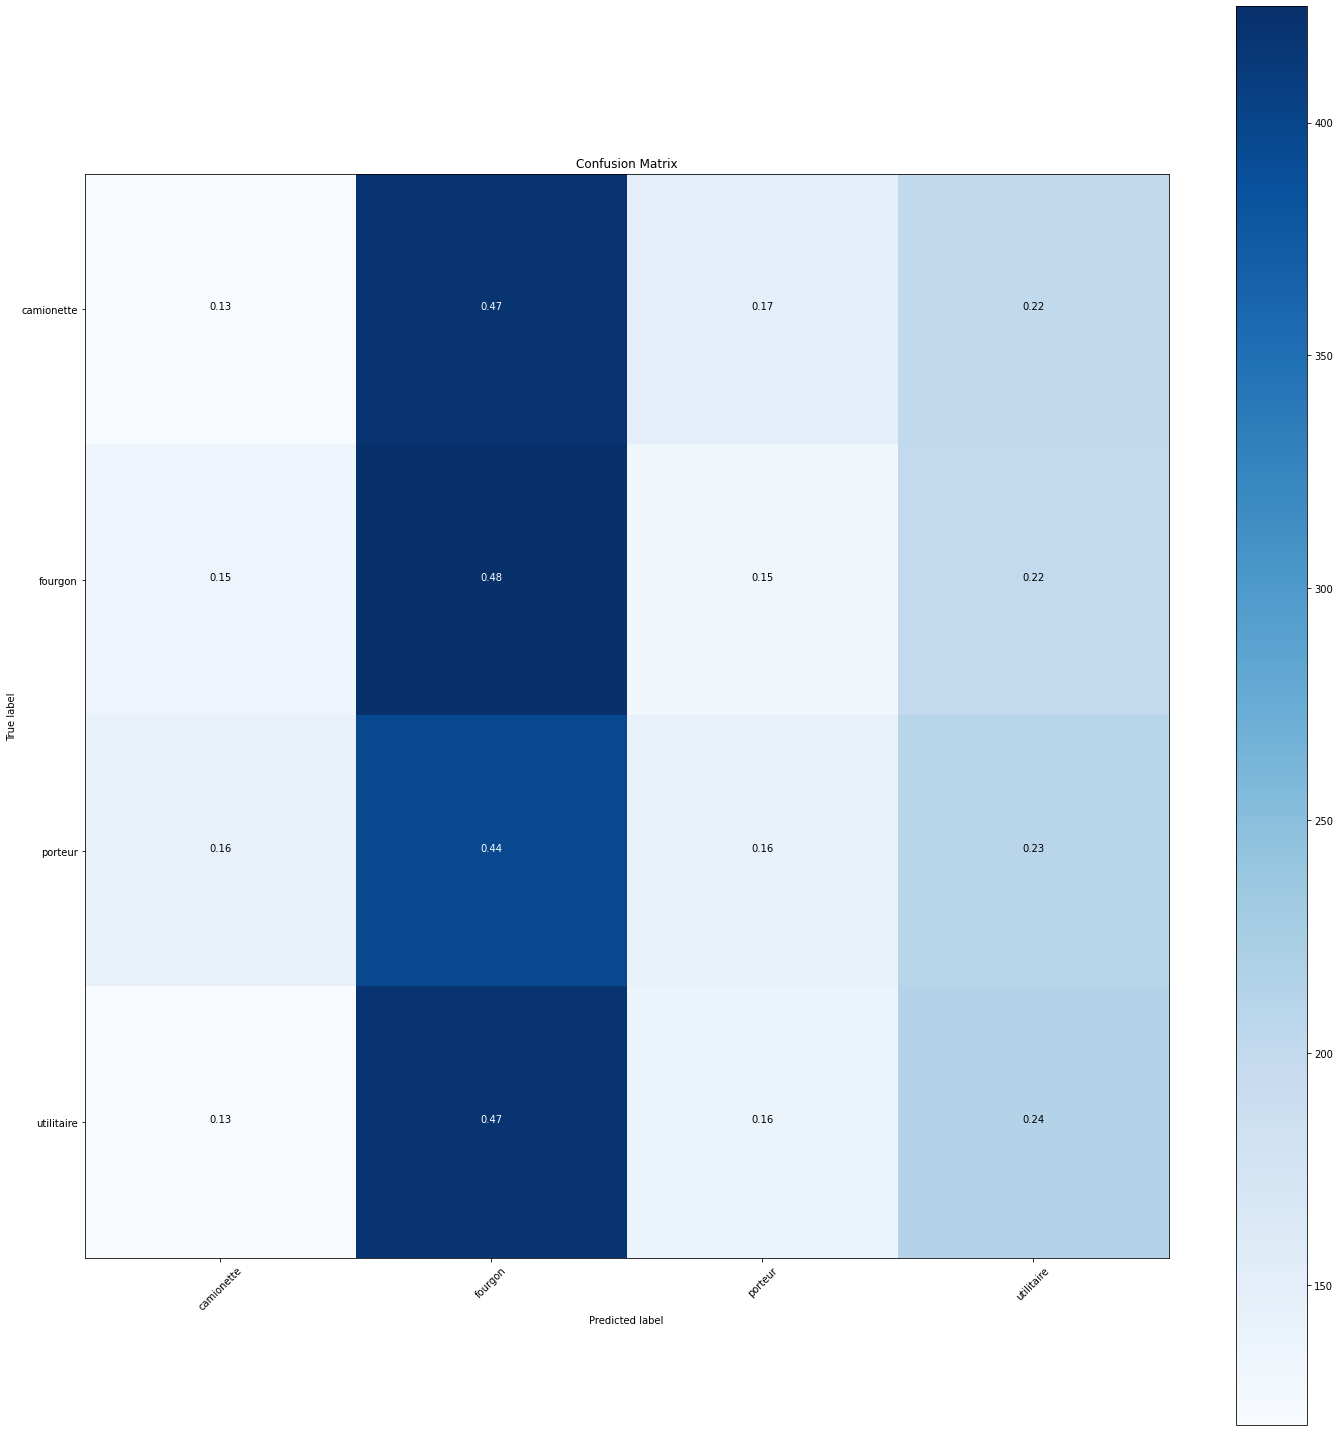

In [ ]:

from matplotlib import cm
import matplotlib.cm as cm
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Text(0.5, 1.0, 'Accuracy Curves')

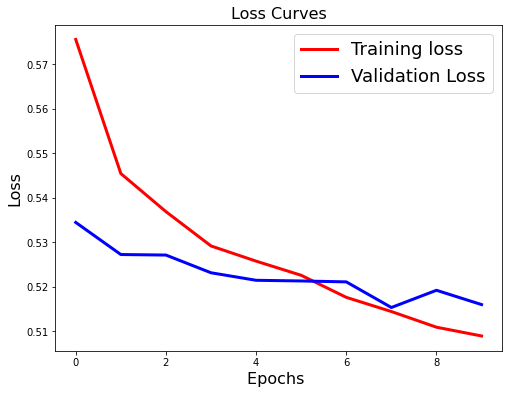

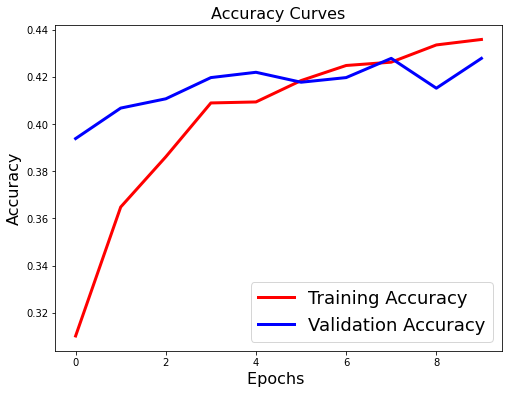

In [71]:
##Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(final_model.history['loss'],'r',linewidth=3.0)
plt.plot(final_model.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(final_model.history['accuracy'],'r',linewidth=3.0)
plt.plot(final_model.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

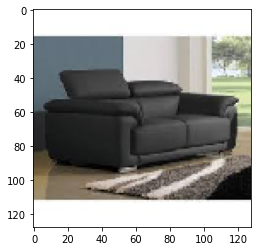

In [ ]:
img_path = '/content/truck_recommandation/dataset/single_prediction/images (2).jpg'

img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
plt.show()

In [ ]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

In [ ]:
prediction = model.predict(x)

In [ ]:
prediction

array([[0.05131766, 0.5456936 , 0.02296335, 0.38002545]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis = 1)
print(classes)

[1]
